# Library Imports & Project Setup

In [1]:
import numpy as np
import pandas as pd
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

c:\Users\mrina\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Colours:
    HEADER = '\033[95m'     # Miscellaneous
    BLUE = '\033[94m'       # Hyperparameters
    GREEN = '\033[92m'      # MAE
    RED = '\033[91m'        # MSE/RMSE
    ENDC = '\033[0m'        # End Colours
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
# Set up GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {Colours.HEADER}{device}{Colours.ENDC}")

Using device: cuda


In [4]:
# Set up Optuna verbosity to see detailed output for every trial
optuna.logging.set_verbosity(optuna.logging.INFO)

# Data Loading & Preprocessing

In [5]:
# Load the training and testing datasets
train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_data = pd.read_csv('Google_Stock_Price_Test.csv')

In [6]:
# Convert columns to numeric by removing commas explicitly
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    # Convert to string, remove commas, and convert to float
    train_data[col] = train_data[col].astype(str).str.replace(',', '').astype(float)
    test_data[col] = test_data[col].astype(str).str.replace(',', '').astype(float)

# Drop the 'Date' column for training, as it's not needed
train_data = train_data.drop(['Date'], axis=1)
test_data = test_data.drop(['Date'], axis=1)

# Normalize the features to bring them in the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Convert scaled_train_data to DataFrame for easier handling
scaled_train_df = pd.DataFrame(scaled_train_data, columns=train_data.columns)

# Split the training data into training and validation sets
train_df, val_df = train_test_split(scaled_train_df, test_size=0.2, shuffle=False)

print("\nTraining Data Sample after Scaling:")
print(train_df.head())

print("\nValidation Data Sample after Scaling:")
print(val_df.head())


Training Data Sample after Scaling:
       Open      High       Low     Close    Volume
0  0.085814  0.096401  0.090449  0.237573  0.295258
1  0.097012  0.098344  0.098235  0.241514  0.229936
2  0.094334  0.092517  0.094086  0.228781  0.263612
3  0.091562  0.088819  0.088006  0.216419  0.216179
4  0.079842  0.076718  0.061070  0.178548  0.467797

Validation Data Sample after Scaling:
          Open      High       Low     Close    Volume
1006  0.862936  0.864381  0.860055  0.345410  0.130753
1007  0.869354  0.879209  0.874034  0.346430  0.077805
1008  0.838753  0.870207  0.855622  0.347863  0.077657
1009  0.839330  0.853997  0.836945  0.324118  0.118374
1010  0.841450  0.844156  0.825466  0.307691  0.097837


# Sequence Creation

In [7]:
# Function to create sequences using PyTorch tensors
def create_sequences_torch(data, sequence_length, device):
    X = []
    y = []

    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i + sequence_length].values)   # Features over the sequence length
        y.append(data['Close'].iloc[i + sequence_length])   # Target value (Close price)

    # Convert lists to NumPy arrays and then to PyTorch tensors
    X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y = torch.tensor(np.array(y), dtype=torch.float32).to(device)

    return X, y

# Define the sequence length for the training and validation sets
sequence_length = 30    # Using 30 days to predict the next day's price

# Create sequences for training and validation using the defined sequence length
X_train, y_train = create_sequences_torch(train_df, sequence_length, device)
X_val, y_val = create_sequences_torch(val_df, sequence_length, device)
X_trainval, y_trainval = create_sequences_torch(scaled_train_df, sequence_length, device)

# Use a smaller sequence length for the testing set (10 days)
test_sequence_length = 10
X_test, y_test = create_sequences_torch(pd.DataFrame(scaled_test_data, columns=train_data.columns), test_sequence_length, device)

# Display the shape of the created sequences
print(f"Training set: X_train shape: {Colours.BOLD}{X_train.shape}{Colours.ENDC}, y_train shape: {Colours.BOLD}{y_train.shape}{Colours.ENDC}")
print(f"Validation set: X_val shape: {Colours.BOLD}{X_val.shape}{Colours.ENDC}, y_val shape: {Colours.BOLD}{y_val.shape}{Colours.ENDC}")
print(f"TrainVal Set: X_trainval shape: {Colours.BOLD}{X_trainval.shape}{Colours.ENDC}, y_trainval shape: {Colours.BOLD}{y_trainval.shape}{Colours.ENDC}")
print(f"Testing set: X_test shape: {Colours.BOLD}{X_test.shape}{Colours.ENDC}, y_test shape: {Colours.BOLD}{y_test.shape}{Colours.ENDC}")

Training set: X_train shape: torch.Size([976, 30, 5]), y_train shape: torch.Size([976])
Validation set: X_val shape: torch.Size([222, 30, 5]), y_val shape: torch.Size([222])
TrainVal Set: X_trainval shape: torch.Size([1228, 30, 5]), y_trainval shape: torch.Size([1228])
Testing set: X_test shape: torch.Size([10, 10, 5]), y_test shape: torch.Size([10])


# Recurrent Neural Network (RNN) Architecture Implementations

## Vanilla RNN

In [8]:
# Define a Vanilla RNN Model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Define the RNN layer(s)
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
        
        # Define the fully connected output layer(s)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)

        # RNN layer(s)
        out, _ = self.rnn(x, h0)

        # Fully connected output (only use the last time step)
        out = out[:, -1, :]
        out = self.fc(out)

        return out

## Long Short-Term Memory (LSTM)

In [9]:
# Define a LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Define the LSTM layer(s)
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)

        # Define the fully connected output layer(s)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM layer(s)
        out, _ = self.lstm(x)

        # Fully connected output (only use the last time step)
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

## Gated Recurrent Unit (GRU)

In [10]:
# Define a GRU Model
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Define the GRU layer(s)
        self.gru = nn.GRU(input_size, hidden_size, n_layers, batch_first=True)

        # Define the fully connected output layer(s)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # GRU layer(s)
        out, _ = self.gru(x)

        # Fully connected output (only use the last time step)
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

# Hyperparameter Tuning

In [11]:
# Define the input and output sizes for the model
input_size = 5  # Number of input features (Open, High, Low, Close, Volume)
output_size = 1 # Output size (predicting the next day's Close price)

## Vanilla RNN Tuning

In [12]:
# Objective function for Optuna (Vanilla RNN)
def vanilla_objective(trial):
    # Suggest values for hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 128)                     # Suggest hidden size between 32 and 128
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)  # Learning rate between 0.0001 and 0.01
    n_layers = trial.suggest_int('n_layers', 1, 2)                              # Number of RNN layers (1 or 2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])          # Batch size can be 16, 32, or 64

    # Initialize the Vanilla RNN model with suggested hyperparameters
    vanilla_model = VanillaRNN(input_size, hidden_size, output_size, n_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(vanilla_model.parameters(), lr=learning_rate)

    # Training Loop (shortened for tuning purposes)
    num_epochs = 20
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    vanilla_model.train()

    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            # Move batch data to GPU if available
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = vanilla_model(X_batch).squeeze(-1)    # Remove extra dimension to match target shape
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation Loss Calculation
    vanilla_model.eval()
    with torch.no_grad():
        val_outputs = vanilla_model(X_val).squeeze()    # Remove any extra dimensions to match target shape
        val_loss = criterion(val_outputs, y_val)

    # Return the validation loss as the metric to minimize
    return val_loss.item()

# Set up Optuna study for Vanilla RNN
vanilla_study = optuna.create_study(direction='minimize', study_name="Vanilla RNN Tuning")
vanilla_study.optimize(vanilla_objective, n_trials=50)

# Print the best hyperparameters for Vanilla RNN
print(f"\n{Colours.UNDERLINE}Best Hyperparameters:{Colours.ENDC}")
print(vanilla_study.best_params)

[I 2024-12-07 13:28:36,887] A new study created in memory with name: Vanilla RNN Tuning
[I 2024-12-07 13:28:40,140] Trial 0 finished with value: 0.0003394332015886903 and parameters: {'hidden_size': 110, 'learning_rate': 0.00383374459517424, 'n_layers': 1, 'batch_size': 32}. Best is trial 0 with value: 0.0003394332015886903.
[I 2024-12-07 13:28:42,924] Trial 1 finished with value: 0.00019727916514966637 and parameters: {'hidden_size': 58, 'learning_rate': 0.0034525166632882985, 'n_layers': 1, 'batch_size': 16}. Best is trial 1 with value: 0.00019727916514966637.
[I 2024-12-07 13:28:44,723] Trial 2 finished with value: 0.0004936819314025342 and parameters: {'hidden_size': 82, 'learning_rate': 0.0018249161261578181, 'n_layers': 2, 'batch_size': 32}. Best is trial 1 with value: 0.00019727916514966637.
[I 2024-12-07 13:28:46,466] Trial 3 finished with value: 0.0326431542634964 and parameters: {'hidden_size': 94, 'learning_rate': 0.0061033458479866414, 'n_layers': 2, 'batch_size': 32}. Best


Best Hyperparameters:
{'hidden_size': 49, 'learning_rate': 0.0026993213442823077, 'n_layers': 2, 'batch_size': 16}


## LSTM Tuning

In [13]:
# Objective function for Optuna (LSTM Model)
def lstm_objective(trial):
    # Suggest values for hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 128)                     # Suggest hidden size between 32 and 128
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)  # Learning rate between 0.0001 and 0.01
    n_layers = trial.suggest_int('n_layers', 1, 2)                              # Number of LSTM layers (1 or 2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])          # Batch size can be 16, 32, or 64

    # Initialize the LSTM model with suggested hyperparameters
    lstm_model = LSTM(input_size, hidden_size, output_size, n_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

    # Training Loop (shortened for tuning purposes)
    num_epochs = 20
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    lstm_model.train()

    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            # Move batch data to GPU if available
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = lstm_model(X_batch).squeeze()  # Remove extra dimension to match target shape
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation Loss Calculation
    lstm_model.eval()
    with torch.no_grad():
        val_outputs = lstm_model(X_val).squeeze()    # Remove extra dimension to match target shape
        val_loss = criterion(val_outputs, y_val)

    # Return the validation loss as the metric to minimize
    return val_loss.item()

# Set up Optuna study for LSTM
lstm_study = optuna.create_study(direction='minimize', study_name="LSTM Tuning")
lstm_study.optimize(lstm_objective, n_trials=50)

# Print the best hyperparameters for LSTM
print(f"\n{Colours.UNDERLINE}Best Hyperparameters for LSTM:{Colours.ENDC}")
print(lstm_study.best_params)

[I 2024-12-07 13:30:10,885] A new study created in memory with name: LSTM Tuning
[I 2024-12-07 13:30:12,406] Trial 0 finished with value: 0.0004052016884088516 and parameters: {'hidden_size': 116, 'learning_rate': 0.0022826731911940296, 'n_layers': 1, 'batch_size': 32}. Best is trial 0 with value: 0.0004052016884088516.
[I 2024-12-07 13:30:14,177] Trial 1 finished with value: 0.0003598589973989874 and parameters: {'hidden_size': 105, 'learning_rate': 0.0003845131058186688, 'n_layers': 2, 'batch_size': 32}. Best is trial 1 with value: 0.0003598589973989874.
[I 2024-12-07 13:30:17,517] Trial 2 finished with value: 0.00118442892562598 and parameters: {'hidden_size': 35, 'learning_rate': 0.0012285312478367617, 'n_layers': 2, 'batch_size': 16}. Best is trial 1 with value: 0.0003598589973989874.
[I 2024-12-07 13:30:20,349] Trial 3 finished with value: 0.00023881765082478523 and parameters: {'hidden_size': 107, 'learning_rate': 0.0007480222578389705, 'n_layers': 1, 'batch_size': 16}. Best is 


Best Hyperparameters for LSTM:
{'hidden_size': 83, 'learning_rate': 0.009632536486326362, 'n_layers': 1, 'batch_size': 32}


## GRU Tuning

In [14]:
# Objective function for Optuna (GRU Model)
def gru_objective(trial):
    # Suggest values for hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 128)                     # Suggest hidden size between 32 and 128
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)  # Learning rate between 0.0001 and 0.01
    n_layers = trial.suggest_int('n_layers', 1, 2)                              # Number of GRU layers (1 or 2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])          # Batch size can be 16, 32, or 64

    # Initialize the GRU model with suggested hyperparameters
    gru_model = GRU(input_size, hidden_size, output_size, n_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)

    # Training Loop (shortened for tuning purposes)
    num_epochs = 20
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    gru_model.train()

    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            # Move batch data to GPU if available
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = gru_model(X_batch).squeeze()  # Remove extra dimension to match target shape
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation Loss Calculation
    gru_model.eval()
    with torch.no_grad():
        val_outputs = gru_model(X_val).squeeze()    # Remove extra dimension to match target shape
        val_loss = criterion(val_outputs, y_val)

    # Return the validation loss as the metric to minimize
    return val_loss.item()

# Set up Optuna study for GRU
gru_study = optuna.create_study(direction='minimize', study_name="GRU Tuning")
gru_study.optimize(gru_objective, n_trials=50)

# Print the best hyperparameters for GRU
print(f"\n{Colours.UNDERLINE}Best Hyperparameters for GRU:{Colours.ENDC}")
print(gru_study.best_params)

[I 2024-12-07 13:31:46,265] A new study created in memory with name: GRU Tuning
[I 2024-12-07 13:31:47,259] Trial 0 finished with value: 0.0015064333565533161 and parameters: {'hidden_size': 99, 'learning_rate': 0.003351535861545134, 'n_layers': 2, 'batch_size': 64}. Best is trial 0 with value: 0.0015064333565533161.
[I 2024-12-07 13:31:48,982] Trial 1 finished with value: 0.00026659833383746445 and parameters: {'hidden_size': 106, 'learning_rate': 0.008849119197748879, 'n_layers': 2, 'batch_size': 32}. Best is trial 1 with value: 0.00026659833383746445.
[I 2024-12-07 13:31:50,700] Trial 2 finished with value: 0.0019555201288312674 and parameters: {'hidden_size': 33, 'learning_rate': 0.0035000306165464943, 'n_layers': 2, 'batch_size': 32}. Best is trial 1 with value: 0.00026659833383746445.
[I 2024-12-07 13:31:53,934] Trial 3 finished with value: 0.0002922290004789829 and parameters: {'hidden_size': 37, 'learning_rate': 0.005339569117873165, 'n_layers': 2, 'batch_size': 16}. Best is tr


Best Hyperparameters for GRU:
{'hidden_size': 81, 'learning_rate': 0.0039021855063393197, 'n_layers': 1, 'batch_size': 16}


# Preliminary Training & Validation

In [15]:
def mean_directional_accuracy(predictions, actuals):
    # Calculate the directional change
    pred_change = predictions[1:] - predictions[:-1]
    actual_change = actuals[1:] - actuals[:-1]

    # Calculate MDA as the percentage of matching directions
    mda = (torch.sign(pred_change) == torch.sign(actual_change)).float().mean().item()
    
    return mda

def r_squared(predictions, actuals):
    # Calculate mean of actuals
    mean_actuals = torch.mean(actuals)
    
    # Calculate total sum of squares (variance of actuals)
    total_sum_of_squares = torch.sum((actuals - mean_actuals) ** 2)
    
    # Calculate residual sum of squares (difference between actuals and predictions)
    residual_sum_of_squares = torch.sum((actuals - predictions) ** 2)
    
    # Calculate R-squared score
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
    
    return r2.item()

## Vanilla RNN Training & Validation

In [16]:
# Initialize the Vanilla RNN model with best hyperparameters
best_vanilla_model = VanillaRNN(input_size, hidden_size=vanilla_study.best_params['hidden_size'], output_size=output_size, n_layers=vanilla_study.best_params['n_layers']).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(best_vanilla_model.parameters(), lr=vanilla_study.best_params['learning_rate'])

num_epochs = 50 # Number of epochs increased to train the model thoroughly

# Set up DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=vanilla_study.best_params['batch_size'], shuffle=True)

# Lists to store metrics for visualization
vanilla_training_loss = []
vanilla_training_mda = []
vanilla_validation_loss = []
vanilla_validation_mda = []

# Training loop
for epoch in range(num_epochs):
    best_vanilla_model.train()

    total_loss = 0
    total_mda = 0

    for X_batch, y_batch in train_loader:
        # Move batch data to GPU if available
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = best_vanilla_model(X_batch).squeeze() # Remove extra dimension to match target shape
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for training
        total_loss += loss.item()

        # Calculate MDA for the batch and accumulate
        batch_mda = mean_directional_accuracy(outputs, y_batch)
        total_mda += batch_mda

    # Calculate average loss and MDA for the epoch
    avg_training_loss = total_loss / len(train_loader)
    avg_training_mda = total_mda / len(train_loader)

    vanilla_training_loss.append(avg_training_loss)
    vanilla_training_mda.append(avg_training_mda)

    # Validation Phase
    best_vanilla_model.eval()
    with torch.no_grad():
        val_outputs = best_vanilla_model(X_val).squeeze()  # Remove extra dimension to match target shape
        val_loss_value = criterion(val_outputs, y_val).item()

        # Calculate MDA for validation
        val_mda_value = mean_directional_accuracy(val_outputs, y_val)

    vanilla_validation_loss.append(val_loss_value)
    vanilla_validation_mda.append(val_mda_value)

    # Print epoch metrics every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {Colours.RED}{avg_training_loss:.4f}{Colours.ENDC}, Training MDA: {Colours.GREEN}{avg_training_mda:.4f}{Colours.ENDC}")
        print(f"Validation Loss: {Colours.RED}{val_loss_value:.4f}{Colours.ENDC}, Validation MDA: {Colours.GREEN}{val_mda_value:.4f}{Colours.ENDC}")

Epoch [2/50], Training Loss: 0.0018, Training MDA: 0.9607
Validation Loss: 0.0032, Validation MDA: 0.5204
Epoch [4/50], Training Loss: 0.0015, Training MDA: 0.9650
Validation Loss: 0.0052, Validation MDA: 0.5023
Epoch [6/50], Training Loss: 0.0012, Training MDA: 0.9727
Validation Loss: 0.0020, Validation MDA: 0.4842
Epoch [8/50], Training Loss: 0.0012, Training MDA: 0.9760
Validation Loss: 0.0003, Validation MDA: 0.4932
Epoch [10/50], Training Loss: 0.0016, Training MDA: 0.9672
Validation Loss: 0.0001, Validation MDA: 0.4977
Epoch [12/50], Training Loss: 0.0014, Training MDA: 0.9825
Validation Loss: 0.0005, Validation MDA: 0.5068
Epoch [14/50], Training Loss: 0.0013, Training MDA: 0.9672
Validation Loss: 0.0002, Validation MDA: 0.5068
Epoch [16/50], Training Loss: 0.0013, Training MDA: 0.9683
Validation Loss: 0.0002, Validation MDA: 0.5113
Epoch [18/50], Training Loss: 0.0013, Training MDA: 0.9672
Validation Loss: 0.0007, Validation MDA: 0.5023
Epoch [20/50], Training Loss: 0.0009, Tra

In [17]:
# Validation with the best model
best_vanilla_model.eval()
with torch.no_grad():
    val_outputs = best_vanilla_model(X_val).squeeze()   # Remove extra dimension to match target shape
    val_loss = criterion(val_outputs, y_val)
    val_mda = mean_directional_accuracy(val_outputs, y_val)
    r2_score = r_squared(val_outputs, y_val)

    print(f"Vanilla RNN Validation Loss (Mean Square Error): {Colours.RED}{val_loss.item()}{Colours.ENDC}")
    print(f"Vanilla RNN Validation Accuracy (Mean Directional Accuracy): {Colours.GREEN}{val_mda * 100:.2f}%{Colours.ENDC}")
    print(f"Vanilla RNN Validation R² Score: {Colours.GREEN}{r2_score:.4f}{Colours.ENDC}")

Vanilla RNN Validation Loss (Mean Square Error): 0.00025231801555491984
Vanilla RNN Validation Accuracy (Mean Directional Accuracy): 52.04%
Vanilla RNN Validation R² Score: 0.8821


## LSTM Training & Validation

In [18]:
# Initialize the LSTM model with best hyperparameters
best_lstm_model = LSTM(input_size, hidden_size=lstm_study.best_params['hidden_size'], output_size=output_size, n_layers=lstm_study.best_params['n_layers']).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(best_lstm_model.parameters(), lr=lstm_study.best_params['learning_rate'])

num_epochs = 50 # Number of epochs increased to train the model thoroughly

# Set up DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=lstm_study.best_params['batch_size'], shuffle=True)

# Lists to store metrics for visualization
lstm_training_loss = []
lstm_training_mda = []
lstm_validation_loss = []
lstm_validation_mda = []

# Training loop
for epoch in range(num_epochs):
    best_lstm_model.train()

    total_loss = 0
    total_mda = 0
    
    for X_batch, y_batch in train_loader:
        # Move batch data to GPU if available
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = best_lstm_model(X_batch).squeeze()    # Remove extra dimension to match target shape
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for training
        total_loss += loss.item()

        # Calculate MDA for the batch and accumulate
        batch_mda = mean_directional_accuracy(outputs, y_batch)
        total_mda += batch_mda

    # Calculate average loss and MDA for the epoch
    avg_training_loss = total_loss / len(train_loader)
    avg_training_mda = total_mda / len(train_loader)

    lstm_training_loss.append(avg_training_loss)
    lstm_training_mda.append(avg_training_mda)

    # Validation Phase
    best_lstm_model.eval()
    with torch.no_grad():
        val_outputs = best_lstm_model(X_val).squeeze()  # Remove extra dimension to match target shape
        val_loss_value = criterion(val_outputs, y_val).item()

        # Calculate MDA for validation
        val_mda_value = mean_directional_accuracy(val_outputs, y_val)

    lstm_validation_loss.append(val_loss_value)
    lstm_validation_mda.append(val_mda_value)

    # Print epoch metrics every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {Colours.RED}{avg_training_loss:.4f}{Colours.ENDC}, Training MDA: {Colours.GREEN}{avg_training_mda:.4f}{Colours.ENDC}")
        print(f"Validation Loss: {Colours.RED}{val_loss_value:.4f}{Colours.ENDC}, Validation MDA: {Colours.GREEN}{val_mda_value:.4f}{Colours.ENDC}")

Epoch [2/50], Training Loss: 0.0025, Training MDA: 0.9447
Validation Loss: 0.0006, Validation MDA: 0.4706
Epoch [4/50], Training Loss: 0.0019, Training MDA: 0.9771
Validation Loss: 0.0021, Validation MDA: 0.5068
Epoch [6/50], Training Loss: 0.0017, Training MDA: 0.9636
Validation Loss: 0.0005, Validation MDA: 0.4977
Epoch [8/50], Training Loss: 0.0012, Training MDA: 0.9646
Validation Loss: 0.0004, Validation MDA: 0.5023
Epoch [10/50], Training Loss: 0.0013, Training MDA: 0.9718
Validation Loss: 0.0004, Validation MDA: 0.4887
Epoch [12/50], Training Loss: 0.0012, Training MDA: 0.9583
Validation Loss: 0.0005, Validation MDA: 0.4751
Epoch [14/50], Training Loss: 0.0016, Training MDA: 0.9708
Validation Loss: 0.0003, Validation MDA: 0.4751
Epoch [16/50], Training Loss: 0.0010, Training MDA: 0.9791
Validation Loss: 0.0002, Validation MDA: 0.4751
Epoch [18/50], Training Loss: 0.0013, Training MDA: 0.9646
Validation Loss: 0.0009, Validation MDA: 0.4661
Epoch [20/50], Training Loss: 0.0010, Tra

In [19]:
# Validation with the best LSTM model
best_lstm_model.eval()
with torch.no_grad():
    val_outputs = best_lstm_model(X_val).squeeze()  # Remove extra dimension to match target shape
    val_loss = criterion(val_outputs, y_val)
    val_mda = mean_directional_accuracy(val_outputs, y_val)
    r2_score = r_squared(val_outputs, y_val)

    print(f"LSTM Validation Loss (Mean Square Error): {Colours.RED}{val_loss.item()}{Colours.ENDC}")
    print(f"LSTM Validation Accuracy (Mean Directional Accuracy): {Colours.GREEN}{val_mda * 100:.2f}%{Colours.ENDC}")
    print(f"LSTM Validation R² Score: {Colours.GREEN}{r2_score:.4f}{Colours.ENDC}")

LSTM Validation Loss (Mean Square Error): 0.00012629905540961772
LSTM Validation Accuracy (Mean Directional Accuracy): 49.77%
LSTM Validation R² Score: 0.9410


## GRU Training & Validation

In [20]:
# Initialize the GRU model with best hyperparameters
best_gru_model = GRU(input_size, hidden_size=gru_study.best_params['hidden_size'], output_size=output_size, n_layers=gru_study.best_params['n_layers']).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(best_gru_model.parameters(), lr=gru_study.best_params['learning_rate'])

num_epochs = 50 # Number of epochs increased to train the model thoroughly

# Set up DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=gru_study.best_params['batch_size'], shuffle=True)

# Lists to store metrics for visualization
gru_training_loss = []
gru_training_mda = []
gru_validation_loss = []
gru_validation_mda = []

# Training loop
for epoch in range(num_epochs):
    best_gru_model.train()

    total_loss = 0
    total_mda = 0

    for X_batch, y_batch in train_loader:
        # Move batch data to GPU if available
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = best_gru_model(X_batch).squeeze() # Remove extra dimension to match target shape
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for training
        total_loss += loss.item()

        # Calculate MDA for the batch and accumulate
        batch_mda = mean_directional_accuracy(outputs, y_batch)
        total_mda += batch_mda

    # Calculate average loss and MDA for the epoch
    avg_training_loss = total_loss / len(train_loader)
    avg_training_mda = total_mda / len(train_loader)

    gru_training_loss.append(avg_training_loss)
    gru_training_mda.append(avg_training_mda)

    # Validation Phase
    best_gru_model.eval()
    with torch.no_grad():
        val_outputs = best_gru_model(X_val).squeeze()  # Remove extra dimension to match target shape
        val_loss_value = criterion(val_outputs, y_val).item()

        # Calculate MDA for validation
        val_mda_value = mean_directional_accuracy(val_outputs, y_val)

    gru_validation_loss.append(val_loss_value)
    gru_validation_mda.append(val_mda_value)

    # Print epoch metrics every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {Colours.RED}{avg_training_loss:.4f}{Colours.ENDC}, Training MDA: {Colours.GREEN}{avg_training_mda:.4f}{Colours.ENDC}")
        print(f"Validation Loss: {Colours.RED}{val_loss_value:.4f}{Colours.ENDC}, Validation MDA: {Colours.GREEN}{val_mda_value:.4f}{Colours.ENDC}")

Epoch [2/50], Training Loss: 0.0016, Training MDA: 0.9781
Validation Loss: 0.0002, Validation MDA: 0.5023
Epoch [4/50], Training Loss: 0.0012, Training MDA: 0.9661
Validation Loss: 0.0009, Validation MDA: 0.4796
Epoch [6/50], Training Loss: 0.0014, Training MDA: 0.9661
Validation Loss: 0.0002, Validation MDA: 0.4751
Epoch [8/50], Training Loss: 0.0013, Training MDA: 0.9781
Validation Loss: 0.0006, Validation MDA: 0.4661
Epoch [10/50], Training Loss: 0.0013, Training MDA: 0.9672
Validation Loss: 0.0001, Validation MDA: 0.4706
Epoch [12/50], Training Loss: 0.0011, Training MDA: 0.9672
Validation Loss: 0.0001, Validation MDA: 0.4842
Epoch [14/50], Training Loss: 0.0014, Training MDA: 0.9716
Validation Loss: 0.0006, Validation MDA: 0.4932
Epoch [16/50], Training Loss: 0.0010, Training MDA: 0.9716
Validation Loss: 0.0002, Validation MDA: 0.4932
Epoch [18/50], Training Loss: 0.0012, Training MDA: 0.9760
Validation Loss: 0.0001, Validation MDA: 0.5068
Epoch [20/50], Training Loss: 0.0010, Tra

In [21]:
# Validation with the best GRU model
best_gru_model.eval()
with torch.no_grad():
    val_outputs = best_gru_model(X_val).squeeze()   # Remove extra dimension to match target shape
    val_loss = criterion(val_outputs, y_val)
    val_mda = mean_directional_accuracy(val_outputs, y_val)
    r2_score = r_squared(val_outputs, y_val)

    print(f"GRU Validation Loss (Mean Square Error): {Colours.RED}{val_loss.item()}{Colours.ENDC}")
    print(f"GRU Validation Accuracy (Mean Directional Accuracy): {Colours.GREEN}{val_mda * 100:.2f}%{Colours.ENDC}")
    print(f"GRU Validation R² Score: {Colours.GREEN}{r2_score:.4f}{Colours.ENDC}")

GRU Validation Loss (Mean Square Error): 0.0001424616202712059
GRU Validation Accuracy (Mean Directional Accuracy): 48.87%
GRU Validation R² Score: 0.9334


# Results of Training & Validation

## Vanilla RNN Visualizations

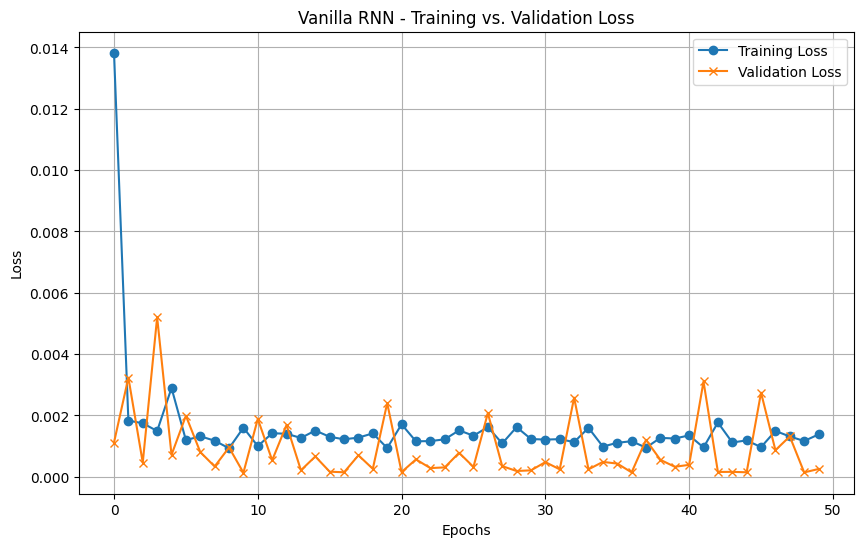

In [22]:
# Plot Training vs. Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(vanilla_training_loss, label='Training Loss', linestyle='-', marker='o')
plt.plot(vanilla_validation_loss, label='Validation Loss', linestyle='-', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Vanilla RNN - Training vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()

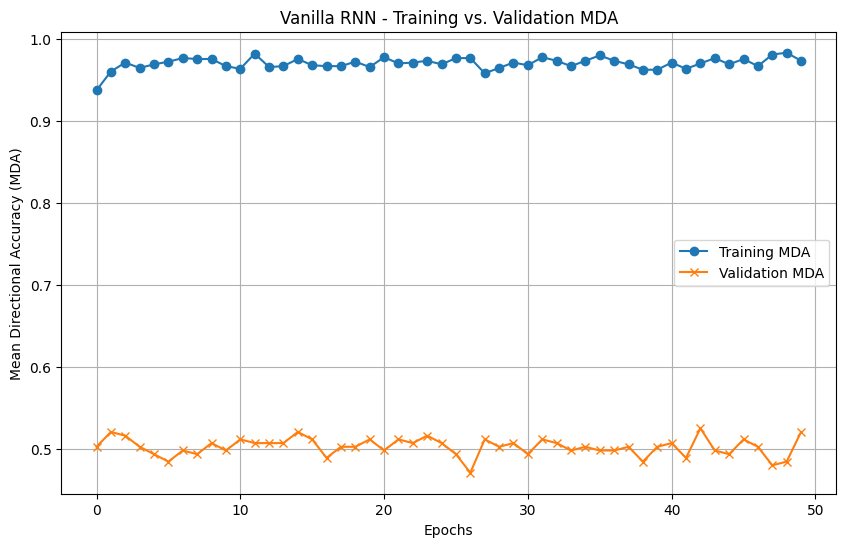

In [23]:
# Plot Training vs. Validation MDA for Vanilla RNN
plt.figure(figsize=(10, 6))
plt.plot(vanilla_training_mda, label='Training MDA', linestyle='-', marker='o')
plt.plot(vanilla_validation_mda, label='Validation MDA', linestyle='-', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Mean Directional Accuracy (MDA)')
plt.title('Vanilla RNN - Training vs. Validation MDA')
plt.legend()
plt.grid()
plt.show()

## LSTM Visualizations

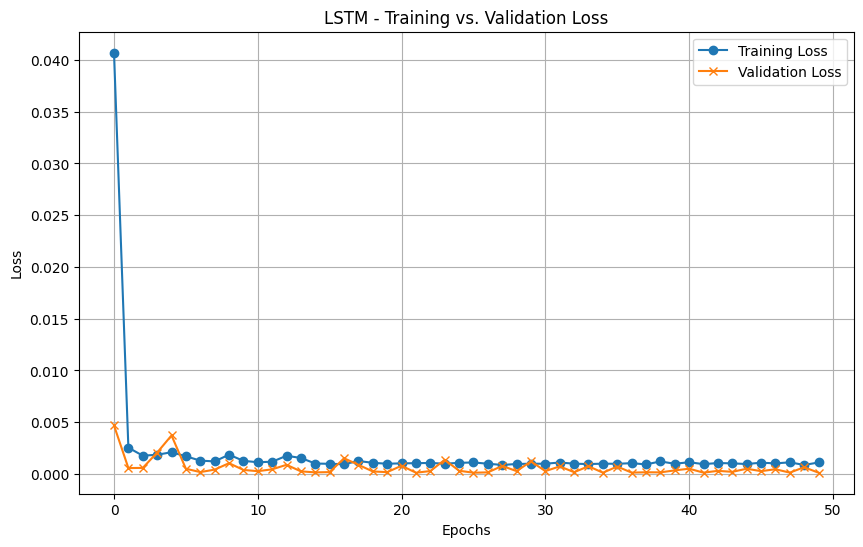

In [24]:
# Plot Training vs. Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(lstm_training_loss, label='Training Loss', linestyle='-', marker='o')
plt.plot(lstm_validation_loss, label='Validation Loss', linestyle='-', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM - Training vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()

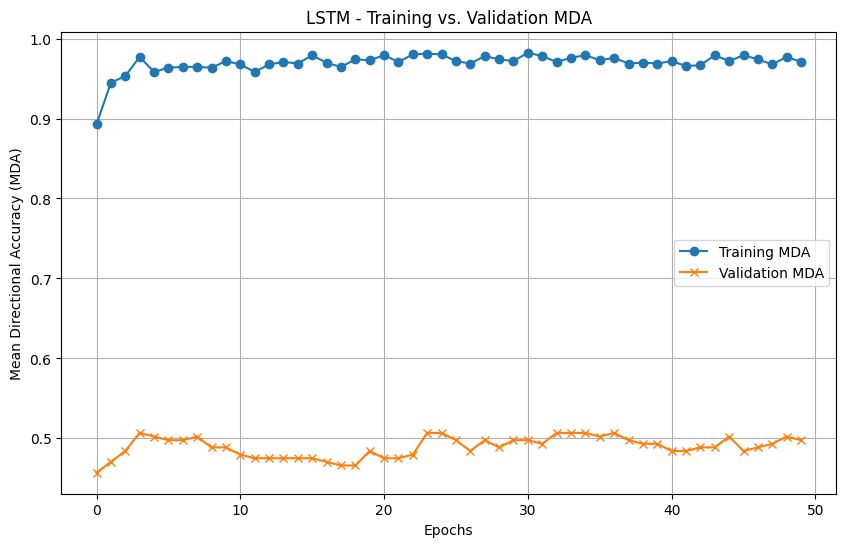

In [25]:
# Plot Training vs. Validation MAE
plt.figure(figsize=(10, 6))
plt.plot(lstm_training_mda, label='Training MDA', linestyle='-', marker='o')
plt.plot(lstm_validation_mda, label='Validation MDA', linestyle='-', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Mean Directional Accuracy (MDA)')
plt.title('LSTM - Training vs. Validation MDA')
plt.legend()
plt.grid()
plt.show()

## GRU Visualizations

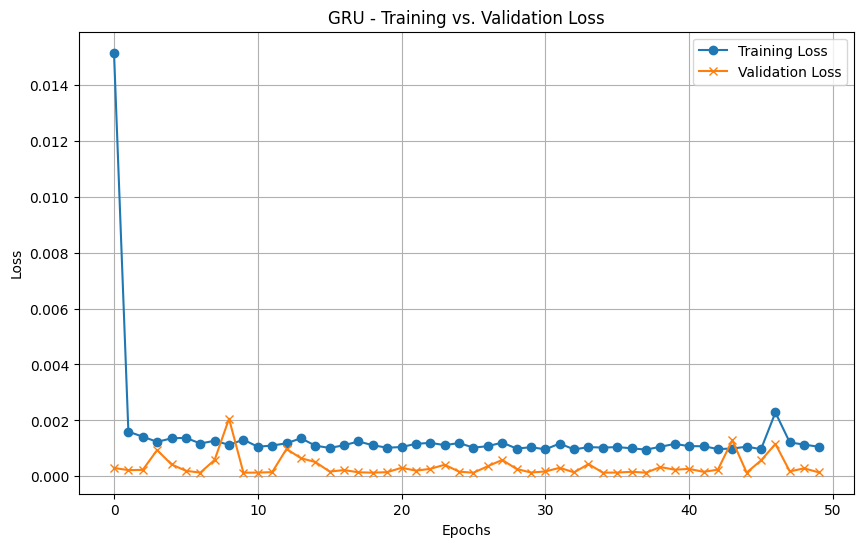

In [26]:
# Plot Training vs. Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(gru_training_loss, label='Training Loss', linestyle='-', marker='o')
plt.plot(gru_validation_loss, label='Validation Loss', linestyle='-', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU - Training vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()

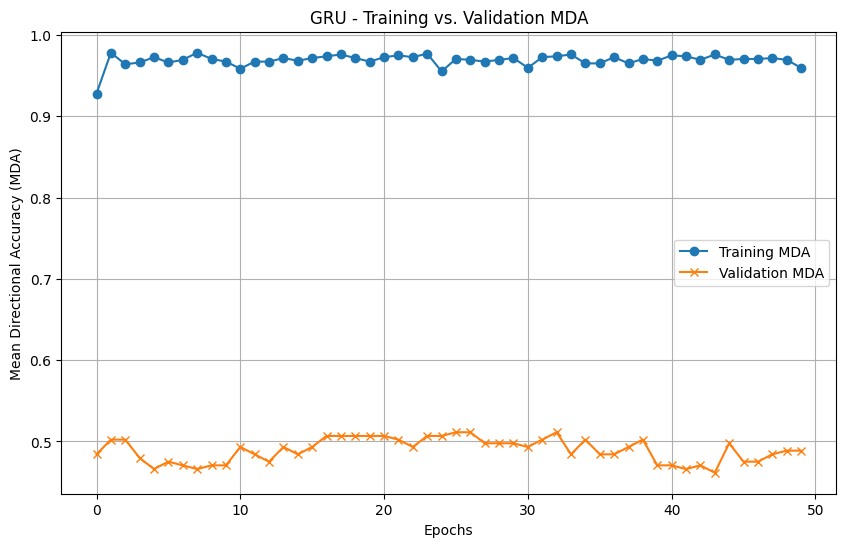

In [27]:
# Plot Training vs. Validation MAE
plt.figure(figsize=(10, 6))
plt.plot(gru_training_mda, label='Training MDA', linestyle='-', marker='o')
plt.plot(gru_validation_mda, label='Validation MDA', linestyle='-', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Mean Directional Accuracy (MDA)')
plt.title('GRU - Training vs. Validation MDA')
plt.legend()
plt.grid()
plt.show()

# Final Training

In [28]:
# Initialize a Vanilla RNN model with the best hyperparameters
vanilla_RNN_model = VanillaRNN(input_size, hidden_size=vanilla_study.best_params['hidden_size'], output_size=output_size, n_layers=vanilla_study.best_params['n_layers']).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(vanilla_RNN_model.parameters(), lr=vanilla_study.best_params['learning_rate'])

# Set up DataLoader for training
trainval_dataset = TensorDataset(X_trainval, y_trainval)
trainval_loader = DataLoader(trainval_dataset, batch_size=vanilla_study.best_params['batch_size'], shuffle=True)

# Train the model using the combined training and validation set
num_epochs = 50  # Number of epochs for final training

vanilla_RNN_model.train()

for epoch in range(num_epochs):
    for X_batch, y_batch in trainval_loader:
        # Move batch data to GPU if available
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = vanilla_RNN_model(X_batch).squeeze()  # Remove extra dimension to match target shape
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print epoch loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {Colours.RED}{loss.item()}{Colours.ENDC}")

Epoch [10/50], Loss: 0.0002189999067923054
Epoch [20/50], Loss: 0.0002974095696117729
Epoch [30/50], Loss: 0.00047226762399077415
Epoch [40/50], Loss: 0.00028442760230973363
Epoch [50/50], Loss: 0.0003021741285920143


In [29]:
# Initialize the model with the best hyperparameters
lstm_model = LSTM(input_size, hidden_size=lstm_study.best_params['hidden_size'], output_size=output_size, n_layers=lstm_study.best_params['n_layers']).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=lstm_study.best_params['learning_rate'])

# Set up DataLoader for training
trainval_dataset = TensorDataset(X_trainval, y_trainval)
trainval_loader = DataLoader(trainval_dataset, batch_size=lstm_study.best_params['batch_size'], shuffle=True)

# Train the model using the combined training and validation set
num_epochs = 50  # Number of epochs for final training

lstm_model.train()

for epoch in range(num_epochs):
    for X_batch, y_batch in trainval_loader:
        # Move batch data to GPU if available
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = lstm_model(X_batch).squeeze()  # Remove extra dimension to match target shape
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print epoch loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {Colours.RED}{loss.item()}{Colours.ENDC}")

Epoch [10/50], Loss: 0.0005638006259687245
Epoch [20/50], Loss: 0.0008843885734677315
Epoch [30/50], Loss: 0.000760235998313874
Epoch [40/50], Loss: 0.0005908546736463904
Epoch [50/50], Loss: 0.0005842146347276866


In [30]:
# Initialize the model with the best hyperparameters
gru_model = GRU(input_size, hidden_size=gru_study.best_params['hidden_size'], output_size=output_size, n_layers=gru_study.best_params['n_layers']).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=gru_study.best_params['learning_rate'])

# Set up DataLoader for training
trainval_dataset = TensorDataset(X_trainval, y_trainval)
trainval_loader = DataLoader(trainval_dataset, batch_size=gru_study.best_params['batch_size'], shuffle=True)

# Train the model using the combined training and validation set
num_epochs = 50  # Number of epochs for final training

gru_model.train()

for epoch in range(num_epochs):
    for X_batch, y_batch in trainval_loader:
        # Move batch data to GPU if available
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = gru_model(X_batch).squeeze()  # Remove extra dimension to match target shape
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print epoch loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {Colours.RED}{loss.item()}{Colours.ENDC}")

Epoch [10/50], Loss: 0.00016881908231880516
Epoch [20/50], Loss: 0.0001524096733191982
Epoch [30/50], Loss: 0.00015573819109704345
Epoch [40/50], Loss: 0.00038779457099735737
Epoch [50/50], Loss: 0.00015868083573877811


# Testing

In [31]:
# Test the model on the test set
vanilla_RNN_model.eval()
with torch.no_grad():
    vanilla_test_outputs = vanilla_RNN_model(X_test).squeeze()  # Remove extra dimension to match target shape
    vanilla_mse = criterion(vanilla_test_outputs, y_test).item()
    vanilla_rmse = torch.sqrt(criterion(vanilla_test_outputs, y_test)).item()
    vanilla_mda = mean_directional_accuracy(vanilla_test_outputs, y_test)
    r2_score = r_squared(vanilla_test_outputs, y_test)

print(f"R-squared for Vanilla RNN: {Colours.GREEN}{r2_score:.4f}{Colours.ENDC}")

R-squared for Vanilla RNN: 0.5466


In [32]:
# Test the model on the test set
lstm_model.eval()
with torch.no_grad():
    lstm_test_outputs = lstm_model(X_test).squeeze()  # Remove extra dimension to match target shape
    lstm_mse = criterion(lstm_test_outputs, y_test).item()
    lstm_rmse = torch.sqrt(criterion(lstm_test_outputs, y_test)).item()
    lstm_mda = mean_directional_accuracy(lstm_test_outputs, y_test)
    r2_score = r_squared(lstm_test_outputs, y_test)

print(f"R-squared for LSTM: {Colours.GREEN}{r2_score:.4f}{Colours.ENDC}")

R-squared for LSTM: 0.2685


In [33]:
# Test the model on the test set
gru_model.eval()
with torch.no_grad():
    gru_test_outputs = gru_model(X_test).squeeze()  # Remove extra dimension to match target shape
    gru_mse = criterion(gru_test_outputs, y_test).item()
    gru_rmse = torch.sqrt(criterion(gru_test_outputs, y_test)).item()
    gru_mda = mean_directional_accuracy(gru_test_outputs, y_test)
    r2_score = r_squared(gru_test_outputs, y_test)

print(f"R-squared for GRU: {Colours.GREEN}{r2_score:.4f}{Colours.ENDC}")

R-squared for GRU: 0.0098


# Final Results

## Performance Summary

In [34]:
# Data for the models
data = {
    'Models': ['RNN', 'LSTM', 'GRU'],
    'MSE': [vanilla_mse, lstm_mse, gru_mse],
    'RMSE': [vanilla_rmse, lstm_rmse, gru_rmse],
    'Accuracy': [vanilla_mda, lstm_mda, gru_mda]
}

print(pd.DataFrame(data))

  Models       MSE      RMSE  Accuracy
0    RNN  0.000148  0.012180  0.666667
1   LSTM  0.000239  0.015471  0.666667
2    GRU  0.000324  0.018000  0.666667


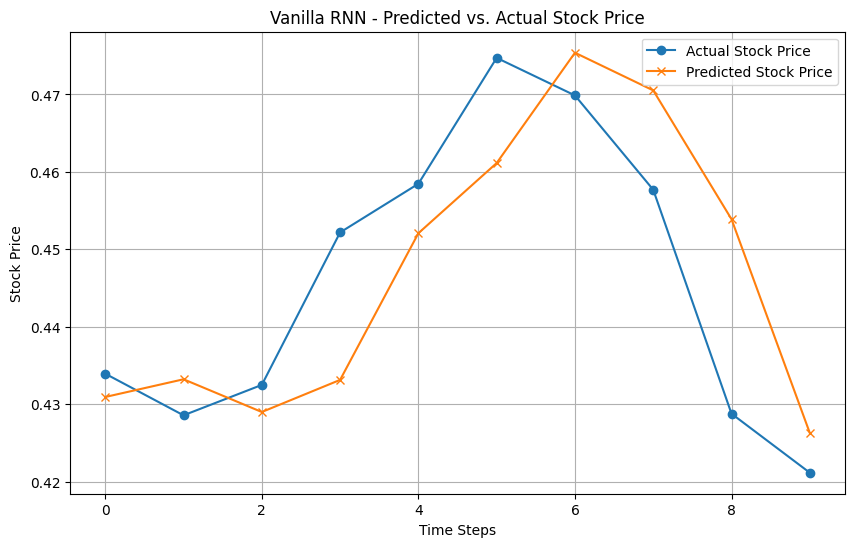

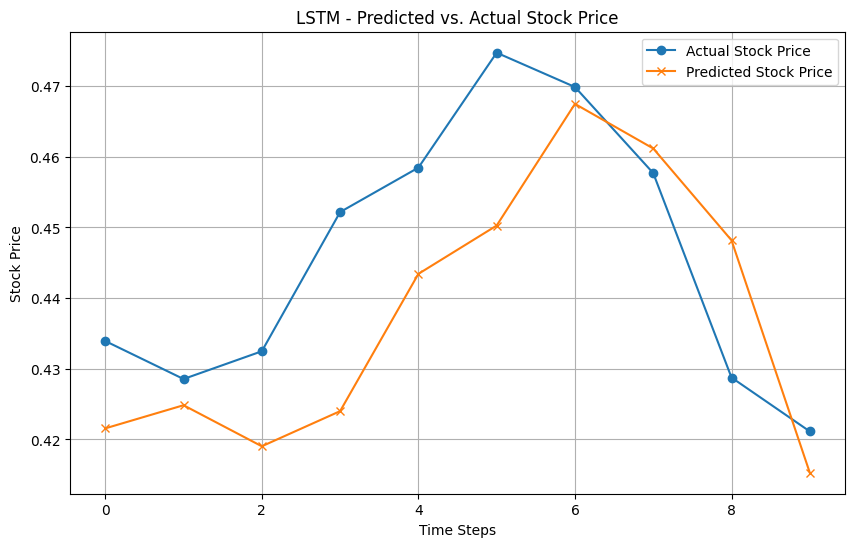

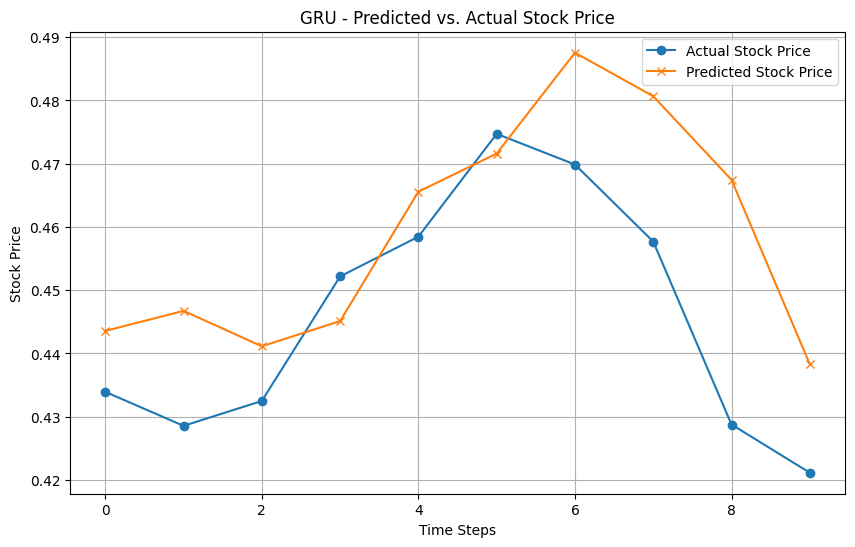

In [36]:
# Plotting Predicted vs Actual Stock Prices
def plot_predictions(model, X_test, y_test, model_name):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.to(device)).squeeze().cpu().numpy()
        actuals = y_test.cpu().numpy()

    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Stock Price', linestyle='-', marker='o')
    plt.plot(predictions, label='Predicted Stock Price', linestyle='-', marker='x')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.title(f'{model_name} - Predicted vs. Actual Stock Price')
    plt.legend()
    plt.grid()
    plt.show()

# Plot Predicted vs Actual for Vanilla RNN
plot_predictions(vanilla_RNN_model, X_test, y_test, 'Vanilla RNN')

# Plot Predicted vs Actual for LSTM
plot_predictions(lstm_model, X_test, y_test, 'LSTM')

# Plot Predicted vs Actual for GRU
plot_predictions(gru_model, X_test, y_test, 'GRU')
